# **Keras Cats vs Dogs - Feature Extraction**

---

Now we will use a pretrained network as a feature extractor. We'll then use those feautres as the input for our Logistic Regression Clasifier.
1. Download and Explore our data
2. Load our pretrained VGG16 Model
3. Extract our Features using VGG16
4. Train a LR Classifier using those features
5. Test some inferences 

## **1. Download and Explore our data**

In [ ]:
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/dogs-vs-cats.zip
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

--2023-02-25 20:03:29--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/dogs-vs-cats.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.149.162
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.149.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 851576689 (812M) [application/zip]
Saving to: ‘dogs-vs-cats.zip’

dogs-vs-cats.zip    100%[===================>] 812.13M  32.2MB/s    in 26s     

2023-02-25 20:03:55 (31.5 MB/s) - ‘dogs-vs-cats.zip’ saved [851576689/851576689]



In [ ]:
import os
import tqdm
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

filenames = os.listdir("./train")

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({'filename': filenames, 'class': categories})
df.head()

,filename,class
0,dog.3870.jpg,1
1,dog.4663.jpg,1
2,dog.4844.jpg,1
3,cat.5287.jpg,0
4,cat.2499.jpg,0


## **2. Load our pretrained VGG16 Model** 

In [ ]:
model = VGG16(weights="imagenet", include_top=False)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

## **3. Extract our Features using VGG16**

In [ ]:
# We're taking the output of the last CONV-POOL layer (see below). 
# The output shape at this layer is (7 x 7 x 512)
batch_size = 32
image_labels = []
image_features = []
image_paths = filenames
labels = categories

# loop over each batch
for i in range(0, len(image_paths)//batch_size):
  
  # extract our batches
  batch_paths = image_paths[i:i + batch_size]
  batch_labels = labels[i:i + batch_size]
  batch_images = []

  # iterate over each image and extract our image features
  for image_path in batch_paths:

    # load images using Keras's load_img() and resize to 224 x 244
    image = load_img('train/'+image_path, target_size = (224, 224))
    image = img_to_array(image)

    # We expand the dimensions and then subtract the mean RGB pixel intensity of ImageNet
    # using the imagenet_utils.preprocess_input() function
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)

    # append our image features to our batch list
    batch_images.append(image)

  # we take our batch of images and get in the right format with vstack
  batch_images = np.vstack(batch_images)

  # we then that batch and run it throuhg our predict function
  features = model.predict(batch_images, batch_size = batch_size)

  # we then take the output shape 7x7x512 and flatten it
  features = np.reshape(features, (-1, 7*7*512))

  # store our features and corresponding labels
  image_features.append(features)
  image_labels.append(batch_labels)

1/1 [==============================] - 0s 29ms/step


In [ ]:
# lets look at the image imageFeatures
print(image_features[0].shape)
image_features[0]
print("\n")

(32, 25088)




## **4. Train a LR Classifier using those features**



In [ ]:
# First let's store our extracted feature info in a format that can loaded directly by sklearn. 
# Take our list of batches and reduce the dimension so that it's now a list 25088 features x 25000 rows (25000 x 1 for our labels)
imageLabels_data =  [lb for label_batch in image_labels for lb in label_batch]
imageFeatures_data = [feature for feature_batch in image_features for feature in feature_batch]

# Convert to numpy arrays
image_labels_data = np.array(imageLabels_data)
image_features_data = np.array(imageFeatures_data)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Split our model into a test and training dataset to train our LR classifier
X_train, X_test, y_train, y_test = train_test_split(image_features_data,
                                                    image_labels_data, 
                                                    test_size = 0.2, 
                                                    random_state = 7)

glm = LogisticRegression(C = 0.1)
glm.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [ ]:
# Get Accruacy on the 20% we split from our training dataset
accuracy = glm.score(X_test, y_test)
print(f'Accuracy on validation set using Logistic Regression: {accuracy*100}%')

Accuracy on validation set using Logistic Regression: 100.0%


## **5. Test some inferences**

In [ ]:
image_names_test = os.listdir("./test1")
image_paths_test = ["./test1/"+ x for x in image_names_test]

In [ ]:
import random 

test_sample = random.sample(image_paths_test, 12)

def test_img():
    result_lst = []
    for path in test_sample:
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        features = model.predict(image)
        features = np.reshape(features,(-1,7*7*512))
        result = glm.predict(features)
        result = 'dog' if float(result) >0.5 else 'cat'
        result_lst.append(result)
    return result_lst

In [ ]:
# get test predictions from all models
pred_results = test_img()
pred_results

1/1 [==============================] - 0s 33ms/step


['dog',
 'dog',
 'dog',
 'cat',
 'cat',
 'cat',
 'cat',
 'dog',
 'cat',
 'cat',
 'dog',
 'dog']

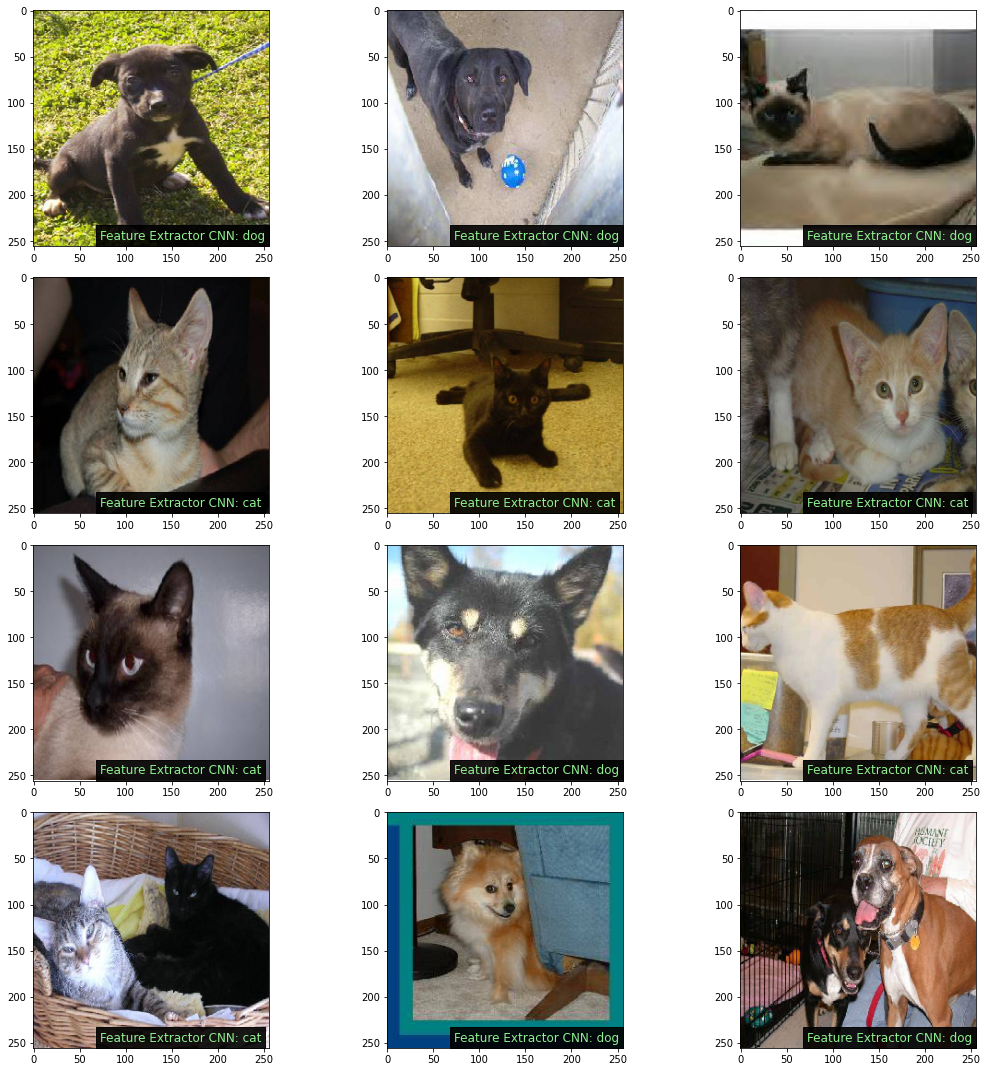

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    result = pred_results[i]
    img = test_sample[i]
    image = load_img(img, target_size=(256,256))
    plt.text(72, 248, f'Feature Extractor CNN: {result}', color='lightgreen',fontsize= 12, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(image)

plt.tight_layout()
plt.show()